In [37]:
import numpy as np
import os
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline


In [38]:
np.random.seed(42)

In [39]:
from dotenv import load_dotenv
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [40]:
tickers = ["SPY", "AGG"]
# YOUR CODE HERE

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    tickers,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df
df.head()


AGG                                        \
                             open      high      low     close   volume   
time                                                                      
2019-11-15 00:00:00-05:00  112.46  112.4600  112.380  112.4100  3961721   
2019-11-18 00:00:00-05:00  112.56  112.6460  112.520  112.5950  5550696   
2019-11-19 00:00:00-05:00  112.63  112.7600  112.600  112.7100  2181200   
2019-11-20 00:00:00-05:00  112.83  112.9800  112.805  112.9700  3218845   
2019-11-21 00:00:00-05:00  112.80  112.8859  112.720  112.8131  3971410   

                              SPY                                    
                             open    high     low   close    volume  
time                                                                 
2019-11-15 00:00:00-05:00  311.02  311.83  310.26  311.82  42549412  
2019-11-18 00:00:00-05:00  311.53  312.28  311.03  312.00  40559312  
2019-11-19 00:00:00-05:00  312.68  312.69  311.22  311.91  56892505  
2019-11-20 00:00:00-05:00  311.28  311.85  309.06  310.79  62833225  
2019-11-21 00:00:00-05:00  310.89  311.01  309.39  310.29  42497606

In [41]:
df.drop(columns=['open', 'high', 'low', 'volume'], level=1, inplace=True)
df.head()


,AGG,SPY
,close,close
time,,
2019-11-15 00:00:00-05:00,112.4100,311.82
2019-11-18 00:00:00-05:00,112.5950,312.00
2019-11-19 00:00:00-05:00,112.7100,311.91
2019-11-20 00:00:00-05:00,112.9700,310.79
2019-11-21 00:00:00-05:00,112.8131,310.29


In [42]:
df.dtypes

AGG  close    float64
SPY  close    float64
dtype: object

# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [43]:
daily_return=df.pct_change().dropna()
daily_return
avg_daily_return_spy = daily_return.mean()['SPY']['close']
avg_daily_return_agg = daily_return.mean()['AGG']['close']
avg_daily_return_agg

0.0004497877647728977

In [44]:
# Calculate volatility
# YOUR CODE HERE
std_daily_spy= daily_return.std()['SPY']['close']
std_daily_agg = daily_return.std()['AGG']['close']
std_daily_agg

#std_daily= daily_return.std()

#std_daily.head()

0.008479347676750357

In [45]:
# Save the last day's closing price
# YOUR CODE HERE
spy_last_price = df['SPY']['close'][-1]
agg_last_price = df['AGG']['close'][-1]


In [50]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

simulated_df = pd.DataFrame()
portfolio_returns = pd.DataFrame()

In [51]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    # YOUR CODE HERE
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy= simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_daily_spy))
        simulated_agg = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_daily_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy)
        simulated_agg_prices.append(simulated_agg)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_df["SPY prices"] = pd.Series(simulated_spy_prices)
    simulated_df["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = simulated_df.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.002394,0.996791,1.033734,1.021837,1.007200,0.978607,0.987407,1.012126,1.023642,0.998950,...,1.001735,1.002595,0.993425,0.983452,0.990528,1.010293,0.975102,0.989032,1.020611,0.985127
2,1.002193,1.006769,1.037775,1.029672,0.957877,0.983455,0.999126,1.021293,1.021552,0.995422,...,1.002132,0.976260,1.016755,0.996905,1.002265,1.009980,0.979870,0.984333,1.012362,0.992988
3,1.009603,1.034764,1.003110,1.014051,0.961169,0.970057,0.982128,1.007513,1.026642,0.997189,...,0.986985,0.980001,1.006379,0.994428,0.988611,0.992736,1.001202,0.998833,1.027539,0.989647
4,0.982929,1.063623,1.019879,1.009709,0.948341,0.983489,0.979112,1.031206,1.018671,0.977774,...,0.986012,0.936291,1.039180,1.004834,0.963346,1.005560,1.032951,0.984500,1.006840,0.983694


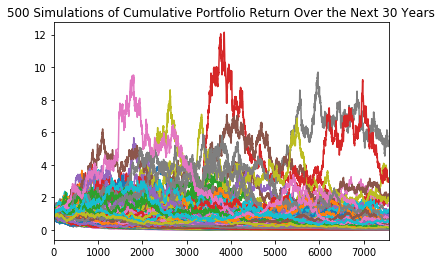

In [74]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"500 Simulations of Cumulative Portfolio Return Over the Next 30 Years"
portfolio_returns.plot(legend=None, title=plot_title)

In [53]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
last_cumulative_returns_30 = portfolio_returns.iloc[252*30, :]
last_cumulative_returns_30.tail()

495    0.344174
496    0.497106
497    0.013640
498    0.174985
499    0.472895
Name: 7560, dtype: float64

In [55]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
cumulative_returns_20 = portfolio_returns.iloc[252*20, :]
cumulative_returns_20.tail()

495    0.462897
496    1.722324
497    0.120176
498    0.217168
499    0.925699
Name: 5040, dtype: float64

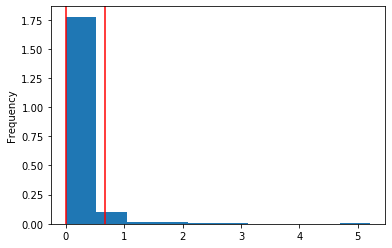

In [81]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE
confidence_interval = last_cumulative_returns_30.quantile(q=[0.05, 0.95])
plt.figure();
last_cumulative_returns_30.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

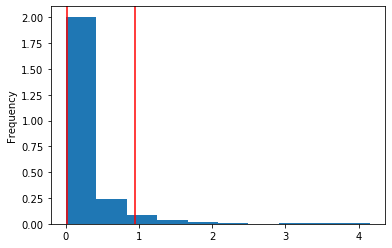

In [60]:
confidence_interval = cumulative_returns_20.quantile(q=[0.05, 0.95])
plt.figure();
cumulative_returns_20.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

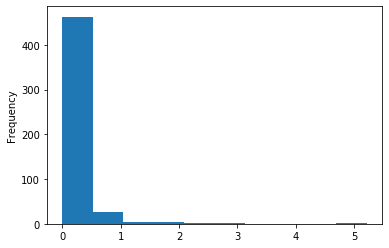

In [62]:
last_cumulative_returns_30.plot(kind='hist', bins=10)

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [64]:
# YOUR CODE HERE
print(f"Expected cumulative portfolio return at 30 years for the 10th % is {round(np.percentile(last_cumulative_returns_30,10),2)}.")
print(f"Expected cumulative portfolio return at 30 years for the 50th % is {round(np.percentile(last_cumulative_returns_30,50),2)}.")
print(f"Expected cumulative portfolio return at 30 years for the 90th % is {round(np.percentile(last_cumulative_returns_30,90),2)}.")

Expected cumulative portfolio return at 30 years for the 10th % is 0.01.
Expected cumulative portfolio return at 30 years for the 50th % is 0.03.
Expected cumulative portfolio return at 30 years for the 90th % is 0.38.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [65]:
# YOUR CODE HERE
initial_investment = 20000
cumulative_pnl = initial_investment * last_cumulative_returns_30
print(f"Expected portfolio return in dollars at the 10th percentile is ${round(np.percentile(cumulative_pnl,10),2)}.")
print(f"Expected portfolio return in dollars at the 50th percentile is ${round(np.percentile(cumulative_pnl,50),2)}.")
print(f"Expected portfolio return in dollars at the 90th percentile is ${round(np.percentile(cumulative_pnl,90),2)}.")

Expected portfolio return in dollars at the 10th percentile is $100.03.
Expected portfolio return in dollars at the 50th percentile is $685.33.
Expected portfolio return in dollars at the 90th percentile is $7662.78.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [66]:
# YOUR CODE HERE
withdraw = 0.04*(round(np.percentile(cumulative_pnl,10),2))
projected_yearly_income=7389

if withdraw >= projected_yearly_income:
    print("4% withdraw is sufficient to cover the projected annual income")
else:
    print("4% withdraw is not sufficient to cover the projected annual income")

4% withdraw is not sufficient to cover the projected annual income


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [70]:
# YOUR CODE HERE
initial_investment_2 = 1.5*initial_investment
cumulative_pnl_2 = initial_investment_2 * last_cumulative_returns_30
withdraw_2 = 0.04*(round(np.percentile(cumulative_pnl_2,10),2))
projected_yearly_income=7389

if withdraw_2 >= projected_yearly_income:
    print("4% withdraw is sufficient to cover the projected annual income")
else:
    print("4% withdraw is not sufficient to cover the projected annual income")

4% withdraw is not sufficient to cover the projected annual income


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

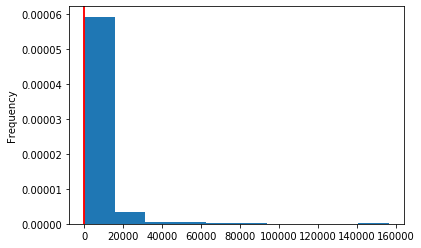

In [73]:
# YOUR CODE HERE
cumilative_pnl = cumulative_pnl_2.quantile(q=[0.05, 0.95])
plt.figure();
cumulative_pnl_2.plot(kind='hist', density=True, bins=10)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')